# COGS 108 - EDA Checkpoint

# Names

- Jianan Liu
- Casey Lee
- Mark Bussard
- Aryan Ziyar
- Hasan Liou

<a id='research_question'></a>
# Research Question

Of a subset of six Twitch streamers, can we reliably identify a particular streamer's chat by performing machine learning analyses on their respective chatlogs? Furthermore, does Twitch emote usage vary from streamer to streamer?

# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import twitch
import urllib
import json
import re

# Data Cleaning

First, we will read in each chatlog locally. To prevent any memory issues, we will be sampling 10,000 chatlogs from each streamer.

In [2]:
# Bring in subsamples of streamers
xqc = pd.read_pickle('Data/xqcow.pkl').sample(10000)
tim = pd.read_pickle('Data/timthetatman.pkl').sample(10000)
tyler1 = pd.read_pickle('Data/loltyler1.pkl').sample(10000)

qtpie = pd.read_pickle('Data/imaqtpie.pkl').sample(10000)
myth = pd.read_pickle('Data/tsm_myth.pkl').sample(10000)
ninja = pd.read_pickle('Data/ninja.pkl').sample(10000) 

Next, we will make use of both the official and a 3rd party Twitch API to obtain ID's for every Global Twitch/BTTV Emote. First, we will utilize the Twitch Python API to get ID numbers of our streamers.

In [3]:
# Get Twitch API keys (stored locally)
with open('api_keys.json') as f:
    keys = json.load(f)

# Get channel ID's from our streamers
helix = twitch.Helix(keys['client_id'], keys['client_secret'])
streamers = ['xqcow', 'timthetatman', 'loltyler1', 'imaqtpie', 'myth', 'ninja']

# Get all streamer ID's
streamer_ids = [helix.user(s).data['id'] for s in streamers]

Then, we will generate a list of Twitch official global emotes, as well as BTTV emotes. For the purposes of this analysis, we will only be studying Twitch official emotes.

In [4]:
# Create list of Twitch official global emotes
with urllib.request.urlopen("https://api.twitchemotes.com/api/v4/channels/0") as url:
    requested = json.loads(url.read().decode())
emote_list = requested['emotes']

# match id's to emotes
id_emote = {}
for emote_dict in emote_list:
    id_emote[emote_dict['id']] = emote_dict['code']
id_list = [int(x['id']) for x in emote_list]

# Get global and channel specific BTTV emotes to throw out of our analysis
bttv_emotes = []
with urllib.request.urlopen("https://api.betterttv.net/3/cached/emotes/global") as url:
    requested = json.loads(url.read().decode())
bttv_emotes = [emote['code'].lower() for emote in requested]

for s in streamer_ids:
    with urllib.request.urlopen("https://api.betterttv.net/3/cached/users/twitch/" + s) as url:
        requested = json.loads(url.read().decode())
        streamer_emotes = [emote['code'].lower() for emote in requested['channelEmotes']]
    bttv_emotes += streamer_emotes

print("Twitch emote ID subset: " + str(id_list[:5]))
print("BTTV Emote subset: " + str(bttv_emotes[:5]))

Twitch emote ID subset: [1, 2, 3, 4, 5]
BTTV Emote subset: [':tf:', 'cigrip', 'datsauce', 'foreveralone', 'gaben']


Here, we will create a new Pandas Series consisting of only Global Emotes.

In [5]:
# Emote function (take only one of each global emote, ignore rest)
def make_emote_list(x):
    lst = []
    # For each fragment
    for fragment in x:
        # Check that we have an emote fragment, and that it is a global emote
        if ('emoticon_id' in fragment.keys()) and (int(fragment['emoticon_id']) in id_list):
            # Add emote
            lst.append(int(fragment['emoticon_id']))
    
    # Save only unique emotes
    return list(set(lst))

# Apply function to dataset fragments
xqc['emotes'] = xqc.fragments.apply(make_emote_list)
tim['emotes'] = tim.fragments.apply(make_emote_list)
tyler1['emotes'] = tyler1.fragments.apply(make_emote_list)

qtpie['emotes'] = qtpie.fragments.apply(make_emote_list)
myth['emotes'] = myth.fragments.apply(make_emote_list)
ninja['emotes'] = ninja.fragments.apply(make_emote_list)

# Example output
test_fragments = [{'emoticon_id': '4'}, {'text': 'sample text'}, {'emoticon_id': '6'}]
print(make_emote_list(test_fragments))

[4, 6]


Finally, we will parse and clean the actual text of each chatlog. Any identifying information, URLs, and chat commands will be removed prior to analysis. Because these streamers speak only English on their channel, we will assume that all text is in English. First, we will extract text from our fragments.

In [6]:
# Take only text (no emotes)
def get_text_only(x):
    # Combines all elements in dict with "text" key
    text_str = " ".join([y['text'] for y in x if 'text' in y.keys()])
    
    # Removes trailing whitespaces and uppercase for analysis
    return text_str.lower().strip()

xqc['text_only'] = xqc.fragments.apply(get_text_only)
tim['text_only'] = tim.fragments.apply(get_text_only)
tyler1['text_only'] = tyler1.fragments.apply(get_text_only)

qtpie['text_only'] = qtpie.fragments.apply(get_text_only)
myth['text_only'] = myth.fragments.apply(get_text_only)
ninja['text_only'] = ninja.fragments.apply(get_text_only)

# Example output
print(get_text_only(test_fragments))

sample text


Next, we will use regex to filter out URLs and chat commands.

In [7]:
# Regex out URLs
regex_str = r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
xqc['text_only'] = xqc.text_only.str.replace(regex_str, '', regex=True)
tim['text_only'] = tim.text_only.str.replace(regex_str, '', regex=True)
tyler1['text_only'] = tyler1.text_only.str.replace(regex_str, '', regex=True)

qtpie['text_only'] = qtpie.text_only.str.replace(regex_str, '', regex=True)
myth['text_only'] = myth.text_only.str.replace(regex_str, '', regex=True)
ninja['text_only'] = ninja.text_only.str.replace(regex_str, '', regex=True)

# Example output
sample_text = 'check out https://github.com/COGS108/group013_sp21 for our project repo, or use !link'
sample_text = re.sub(regex_str, '', sample_text)

# Regex out commands
regex_str = r'\!\w+'

xqc['text_only'] = xqc.text_only.str.replace(regex_str, '', regex=True)
tim['text_only'] = tim.text_only.str.replace(regex_str, '', regex=True)
tyler1['text_only'] = tyler1.text_only.str.replace(regex_str, '', regex=True)

qtpie['text_only'] = qtpie.text_only.str.replace(regex_str, '', regex=True)
myth['text_only'] = myth.text_only.str.replace(regex_str, '', regex=True)
ninja['text_only'] = ninja.text_only.str.replace(regex_str, '', regex=True)

# Example Output
sample_text = re.sub(regex_str, '', sample_text)
print(sample_text)

check out  for our project repo, or use 


Identifying information from each streamer is removed.

In [8]:
# Remove identifying information
xqc_identifying_info = '|'.join(['@xqcow', 'xqcow', 'xqc'])
tim_identifying_info = '|'.join(['@timthetatman', 'timthetatman', 'tatman', 'tim'])
tyler1_identifying_info = '|'.join(['@loltyler1', 'loltyler1', 'tyler1', 'tyler'])

qtpie_identifying_info = '|'.join(['@imaqtpie', 'imaqtpie', 'qtpie', 'qt'])
myth_identifying_info = '|'.join(['@tsm_myth', '@myth', 'tsm_myth', 'myth'])
ninja_identifying_info = '|'.join(['@ninja', 'ninja'])

xqc['text_only'] = xqc.text_only.str.replace(xqc_identifying_info, '', regex=True)
tim['text_only'] = tim.text_only.str.replace(tim_identifying_info, '', regex=True)
tyler1['text_only'] = tyler1.text_only.str.replace(tyler1_identifying_info, '', regex=True)

qtpie['text_only'] = qtpie.text_only.str.replace(qtpie_identifying_info, '', regex=True)
myth['text_only'] = myth.text_only.str.replace(myth_identifying_info, '', regex=True)
ninja['text_only'] = ninja.text_only.str.replace(ninja_identifying_info, '', regex=True)

# Example Output
re.sub(xqc_identifying_info, '', 'i love you @xqcow please respond')

'i love you  please respond'

Finally, any BTTV emotes, stopwords, non-alphanumeric characters, and extra spaces are removed from our set. BTTV emotes are removed because some are channel specific and their associated ID's conflict with Twitch's emote ID's. 

In [9]:
# Keep only alphanumeric characters
regex_str = r'\W'
xqc['text_only'] = xqc.text_only.str.replace(regex_str, ' ', regex=True)
tim['text_only'] = tim.text_only.str.replace(regex_str, ' ', regex=True)
tyler1['text_only'] = tyler1.text_only.str.replace(regex_str, ' ', regex=True)

qtpie['text_only'] = qtpie.text_only.str.replace(regex_str, ' ', regex=True)
myth['text_only'] = myth.text_only.str.replace(regex_str, ' ', regex=True)
ninja['text_only'] = ninja.text_only.str.replace(regex_str, ' ', regex=True)

# Example Output
example = re.sub(regex_str, ' ', 'oh man i need help!!! please @ me for help#!@!#!# karappa')
example

'oh man i need help    please   me for help        karappa'

In [10]:
# Stopwords + bttv emotes + extra spaces
sw = stopwords.words('english') + bttv_emotes

xqc['text_only'] = xqc['text_only'].apply(lambda x: ' '.join([item for item in x.split() if item not in sw]))
tim['text_only'] = tim['text_only'].apply(lambda x: ' '.join([item for item in x.split() if item not in sw]))
tyler1['text_only'] = tyler1['text_only'].apply(lambda x: ' '.join([item for item in x.split() if item not in sw]))

qtpie['text_only'] = qtpie['text_only'].apply(lambda x: ' '.join([item for item in x.split() if item not in sw]))
myth['text_only'] = myth['text_only'].apply(lambda x: ' '.join([item for item in x.split() if item not in sw]))
ninja['text_only'] = ninja['text_only'].apply(lambda x: ' '.join([item for item in x.split() if item not in sw]))

example = ' '.join([item for item in example.split() if item not in sw])
example

'oh man need help please help'

# Data Analysis & Results (EDA)

Before starting, we want to call to attention the existence of Twitch cultures -- from prior Twitch knowledge, we have learned that a running gag on loltyler1's stream is that he is an "Alpha male." To show that this running gag doesn't exist on other channels, we can observe the number of occurrences in each chat.

In [11]:
print('xqcOW: ' + str(len(xqc[xqc['body'].str.contains("alpha")])))
print('TimTheTatMan: ' + str(len(tim[tim['body'].str.contains("alpha")])))
print('loltyler1: ' + str(len(tyler1[tyler1['body'].str.contains("alpha")])))

print('imaqtpie: ' + str(len(qtpie[qtpie['body'].str.contains("alpha")])))
print('TSM_Myth: ' + str(len(myth[myth['body'].str.contains("alpha")])))
print('Ninja: ' + str(len(ninja[ninja['body'].str.contains("alpha")])))

xqcOW: 0
TimTheTatMan: 2
loltyler1: 12
imaqtpie: 3
TSM_Myth: 0
Ninja: 1


The frequency in which "alpha" appears in any one chat is close to 0, with tyler1's chat being the sole exception. With this in mind, we will explore the 10 most common words in each chat to observe whether we can identify a subculture within each chatroom.

In [12]:
# Get top unique words for every streamer
xqc_top = np.array(Counter(" ".join(xqc["text_only"]).split()).most_common(10))
tim_top = np.array(Counter(" ".join(tim["text_only"]).split()).most_common(10))
tyler1_top = np.array(Counter(" ".join(tyler1["text_only"]).split()).most_common(10))

qtpie_top = np.array(Counter(" ".join(qtpie["text_only"]).split()).most_common(10))
myth_top = np.array(Counter(" ".join(myth["text_only"]).split()).most_common(10))
ninja_top = np.array(Counter(" ".join(ninja["text_only"]).split()).most_common(10))

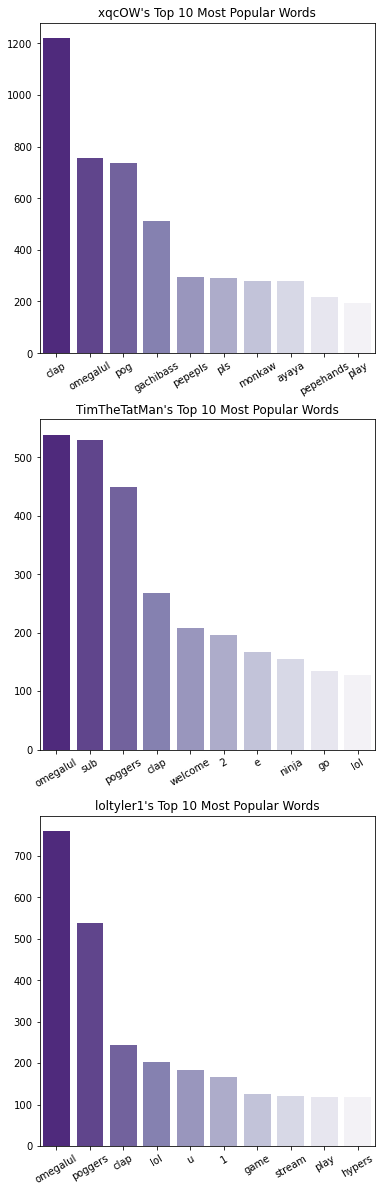

In [13]:
# Plot top 10 words in "funny" streams
plt.subplots_adjust(top = 4, bottom = 0.1)

plt.subplot(3, 1, 1)
ax = sns.barplot(x=xqc_top[:, 0], y=xqc_top[:, 1], palette='Purples_r')
temp = ax.set_title("xqcOW's Top 10 Most Popular Words")
temp = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30)

plt.subplot(3, 1, 2)
ax = sns.barplot(x=tim_top[:, 0], y=tim_top[:, 1], palette='Purples_r')
temp = ax.set_title("TimTheTatMan's Top 10 Most Popular Words")
temp = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30)

plt.subplot(3, 1, 3)
ax = sns.barplot(x=tyler1_top[:, 0], y=tyler1_top[:, 1], palette='Purples_r')
temp = ax.set_title("loltyler1's Top 10 Most Popular Words")
temp = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30)

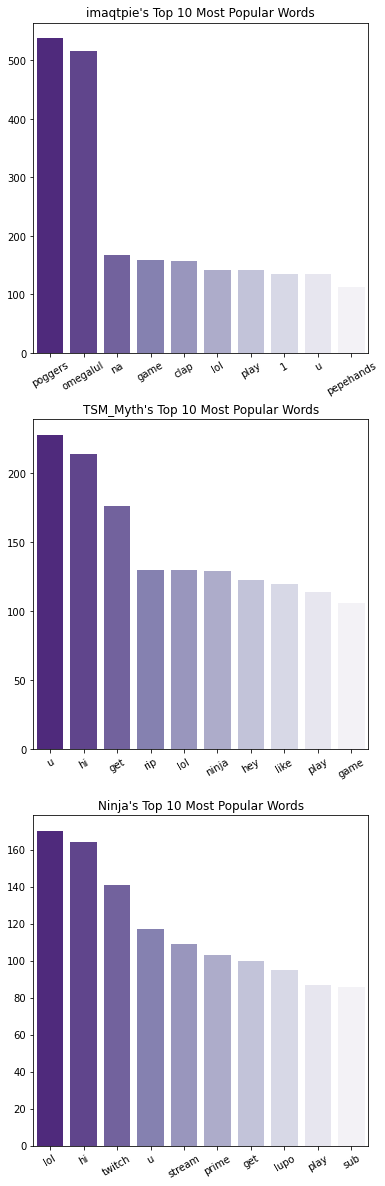

In [14]:
# Plot top 10 words in "serious streams"
plt.subplots_adjust(top = 4, bottom = 0.1)

plt.subplot(3, 1, 1)
ax = sns.barplot(x=qtpie_top[:, 0], y=qtpie_top[:, 1], palette='Purples_r')
temp = ax.set_title("imaqtpie's Top 10 Most Popular Words")
temp = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30)

plt.subplot(3, 1, 2)
ax = sns.barplot(x=myth_top[:, 0], y=myth_top[:, 1], palette='Purples_r')
temp = ax.set_title("TSM_Myth's Top 10 Most Popular Words")
temp = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30)

plt.subplot(3, 1, 3)
ax = sns.barplot(x=ninja_top[:, 0], y=ninja_top[:, 1], palette='Purples_r')
temp = ax.set_title("Ninja's Top 10 Most Popular Words")
temp = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30)

Although there is some overlap, we can observe a fairly clear difference in the word choices between our two categories. Namely, we can see that our "fun" chatrooms have a preferred set of words, namely "omegalul" and "poggers", whereas "serious" chatrooms try to interact with the streamer with greetings, like "hi." 

Interestingly, imaqtpie has a chatroom that seems more aligned with the "fun" streamers -- upon closer inspection, his content has shifted away from serious streams since his retirement from professional leagues.

Overall, there is clearly a difference in mood between these two categories. What about in terms of emote usage?

In [15]:
# Get top emotes in every stream chat
xqc_top_emotes = pd.Series(np.concatenate(xqc['emotes'].to_list()).ravel()).value_counts().iloc[:10].reset_index()
tim_top_emotes = pd.Series(np.concatenate(tim['emotes'].to_list()).ravel()).value_counts().iloc[:10].reset_index()
tyler1_top_emotes = pd.Series(np.concatenate(tyler1['emotes'].to_list()).ravel()).value_counts().iloc[:10].reset_index()

qtpie_top_emotes = pd.Series(np.concatenate(qtpie['emotes'].to_list()).ravel()).value_counts().iloc[:10].reset_index()
myth_top_emotes = pd.Series(np.concatenate(myth['emotes'].to_list()).ravel()).value_counts().iloc[:10].reset_index()
ninja_top_emotes = pd.Series(np.concatenate(ninja['emotes'].to_list()).ravel()).value_counts().iloc[:10].reset_index()

In [16]:
# Apply real emote name by ID
xqc_top_emotes['index'] = xqc_top_emotes['index'].apply(lambda x: id_emote[x])
tim_top_emotes['index'] = tim_top_emotes['index'].apply(lambda x: id_emote[x])
tyler1_top_emotes['index'] = tyler1_top_emotes['index'].apply(lambda x: id_emote[x])

qtpie_top_emotes['index'] = qtpie_top_emotes['index'].apply(lambda x: id_emote[x])
myth_top_emotes['index'] = myth_top_emotes['index'].apply(lambda x: id_emote[x])
ninja_top_emotes['index'] = ninja_top_emotes['index'].apply(lambda x: id_emote[x])

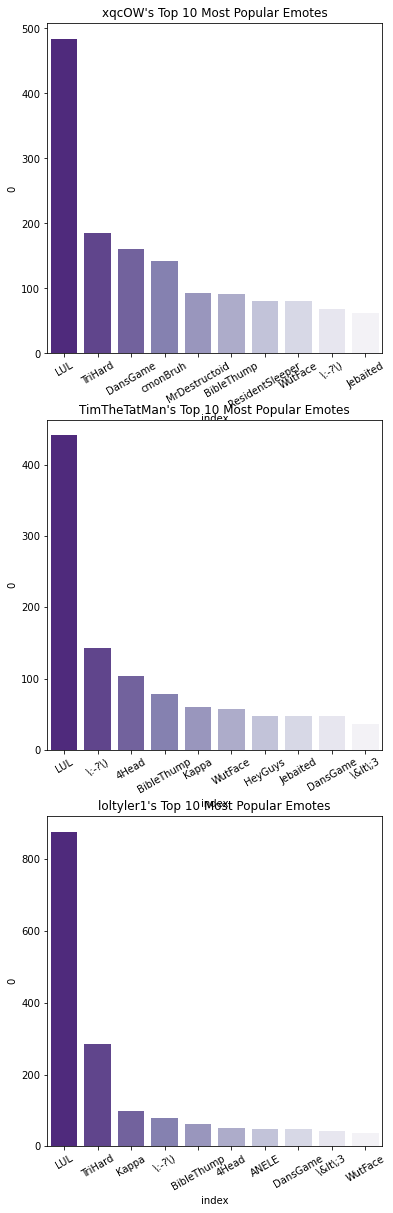

In [17]:
# Show top 10 emotes by fun streamers

plt.subplots_adjust(top = 4, bottom = 0.1)

plt.subplot(3, 1, 1)
ax = sns.barplot(x='index', y=0, data=xqc_top_emotes, palette='Purples_r')
temp = ax.set_title("xqcOW's Top 10 Most Popular Emotes")
temp = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30)

plt.subplot(3, 1, 2)
ax = sns.barplot(x='index', y=0, data=tim_top_emotes, palette='Purples_r')
temp = ax.set_title("TimTheTatMan's Top 10 Most Popular Emotes")
temp = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30)

plt.subplot(3, 1, 3)
ax = sns.barplot(x='index', y=0, data=tyler1_top_emotes, palette='Purples_r')
temp = ax.set_title("loltyler1's Top 10 Most Popular Emotes")
temp = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30)

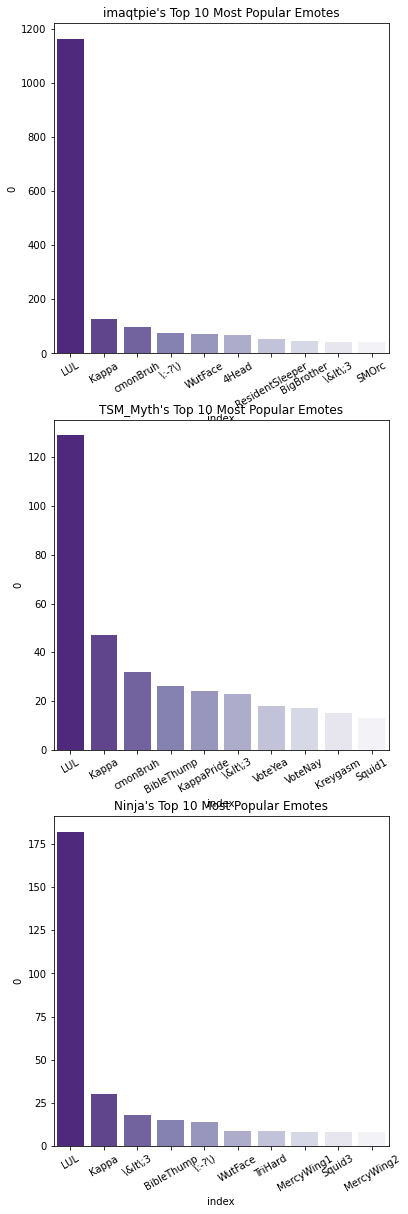

In [18]:
# Show top 10 emotes by serious streamers

plt.subplots_adjust(top = 4, bottom = 0.1)

plt.subplot(3, 1, 1)
ax = sns.barplot(x='index', y=0, data=qtpie_top_emotes, palette='Purples_r')
temp = ax.set_title("imaqtpie's Top 10 Most Popular Emotes")
temp = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30)

plt.subplot(3, 1, 2)
ax = sns.barplot(x='index', y=0, data=myth_top_emotes, palette='Purples_r')
temp = ax.set_title("TSM_Myth's Top 10 Most Popular Emotes")
temp = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30)

plt.subplot(3, 1, 3)
ax = sns.barplot(x='index', y=0, data=ninja_top_emotes, palette='Purples_r')
temp = ax.set_title("Ninja's Top 10 Most Popular Emotes")
temp = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30)

While more subtle, there is still a few notable differences in the emote preferences within each chatroom. LUL, an emote that indicates laughter, is by far the universally most popular emote amongst all streams. As we traverse down, however, we notice changes in preference. Ninja's chat, for instance, uses the Squid emotes for some reason. Meanwhile, PowerUpL and PowerUpR appear to be popular solely in TSM_Myth's stream.

Observing general popularity is a decent statistic, but we should also take into account the most unique words between chatrooms. To do so, we will observe term popularity with respect to the TF-IDF algorithm.

In [19]:
# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, analyzer='word', max_features=100, tokenizer=word_tokenize)

In [20]:
# Create "corpus" (list of strings) for vectorizer

text = []
text.append(' '.join(' '.join(xqc['text_only'].to_list()).split()))
text.append(' '.join(' '.join(tim['text_only'].to_list()).split()))
text.append(' '.join(' '.join(tyler1['text_only'].to_list()).split()))
text.append(' '.join(' '.join(qtpie['text_only'].to_list()).split()))
text.append(' '.join(' '.join(myth['text_only'].to_list()).split()))
text.append(' '.join(' '.join(ninja['text_only'].to_list()).split()))

In [21]:
# Create DataFrame of TF-IDF scores by streamer and word
streamers = ['xqcOW', 'TimTheTatMan', 'loltyler1', 'imaqtpie', 'TSM_Myth', 'Ninja']
twitch_tfidf = pd.DataFrame.sparse.from_spmatrix(tfidf.fit_transform(text), columns=tfidf.get_feature_names(), index=streamers)
twitch_tfidf

,0,1,10,2,3,4,5,7,ayaya,back,...,us,use,want,watch,welcome,win,wtf,x,yes,yo
xqcOW,0.079119,0.095828,0.080634,0.093760,0.078313,0.083344,0.071440,0.108625,0.195740,0.084566,...,0.098275,0.075666,0.079892,0.082038,0.039741,0.068912,0.089716,0.085149,0.093392,0.068912
TimTheTatMan,0.082282,0.098045,0.071763,0.129282,0.096034,0.082282,0.083287,0.073411,0.000000,0.115425,...,0.083287,0.071763,0.091307,0.098045,0.130506,0.097560,0.086037,0.063413,0.102736,0.060664
loltyler1,0.090295,0.123702,0.088990,0.112296,0.108049,0.104310,0.103005,0.114126,0.146244,0.095306,...,0.080791,0.086859,0.085303,0.090917,0.052761,0.096734,0.100496,0.059565,0.097188,0.084478
imaqtpie,0.109419,0.124508,0.098327,0.113210,0.115485,0.105955,0.103140,0.100386,0.085807,0.096046,...,0.096046,0.102261,0.092795,0.090574,0.069632,0.091341,0.110049,0.073476,0.101344,0.071642
TSM_Myth,0.108241,0.111387,0.113551,0.104995,0.102685,0.095849,0.088761,0.083500,0.000000,0.097773,...,0.083500,0.101686,0.101686,0.095168,0.045043,0.098966,0.097773,0.120305,0.112954,0.116563
Ninja,0.075393,0.120762,0.101699,0.116768,0.111103,0.110696,0.112661,0.093609,0.000000,0.111103,...,0.085051,0.109427,0.097654,0.098381,0.087519,0.107138,0.091758,0.065364,0.096902,0.104037


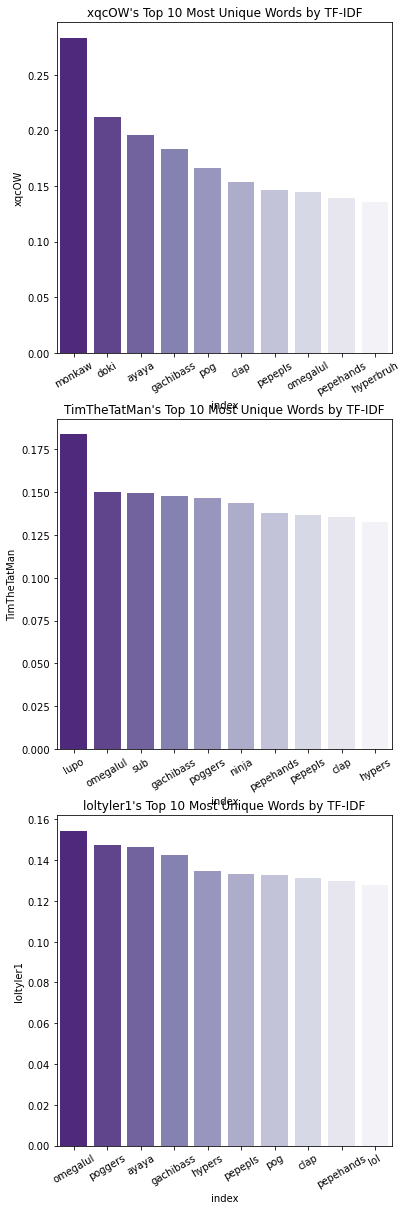

In [22]:
# Plot 10 highest scoring words for fun streamers
plt.subplots_adjust(top = 4, bottom = 0.1)

plt.subplot(3, 1, 1)
ax = sns.barplot(x='index', y='xqcOW', data=twitch_tfidf.loc['xqcOW'].nlargest(10).reset_index(), palette='Purples_r')
temp = ax.set_title("xqcOW's Top 10 Most Unique Words by TF-IDF")
temp = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30)

plt.subplot(3, 1, 2)
ax = sns.barplot(x='index', y='TimTheTatMan', data=twitch_tfidf.loc['TimTheTatMan'].nlargest(10).reset_index(), palette='Purples_r')
temp = ax.set_title("TimTheTatMan's Top 10 Most Unique Words by TF-IDF")
temp = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30)

plt.subplot(3, 1, 3)
ax = sns.barplot(x='index', y='loltyler1', data=twitch_tfidf.loc['loltyler1'].nlargest(10).reset_index(), palette='Purples_r')
temp = ax.set_title("loltyler1's Top 10 Most Unique Words by TF-IDF")
temp = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30)

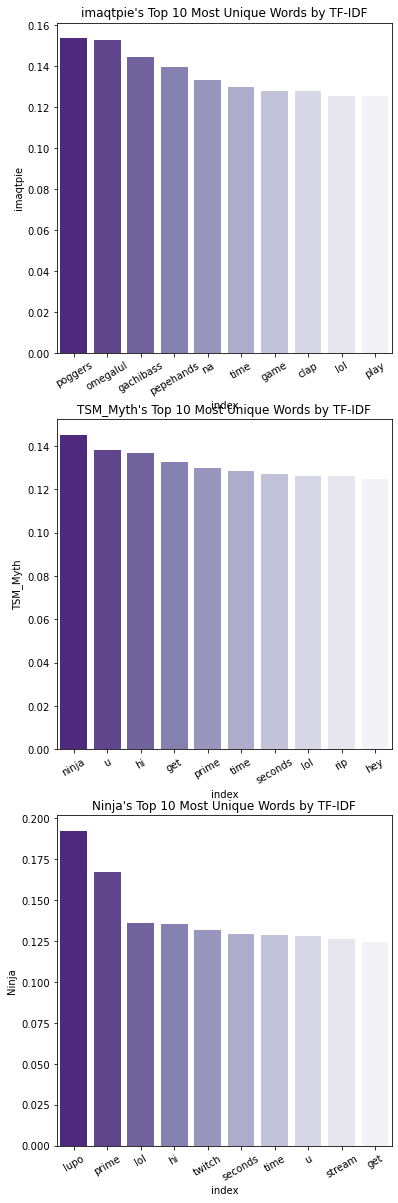

In [23]:
# Plot top 10 highest scoring words for serious streamers

plt.subplots_adjust(top = 4, bottom = 0.1)

plt.subplot(3, 1, 1)
ax = sns.barplot(x='index', y='imaqtpie', data=twitch_tfidf.loc['imaqtpie'].nlargest(10).reset_index(), palette='Purples_r')
temp = ax.set_title("imaqtpie's Top 10 Most Unique Words by TF-IDF")
temp = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30)

plt.subplot(3, 1, 2)
ax = sns.barplot(x='index', y='TSM_Myth', data=twitch_tfidf.loc['TSM_Myth'].nlargest(10).reset_index(), palette='Purples_r')
temp = ax.set_title("TSM_Myth's Top 10 Most Unique Words by TF-IDF")
temp = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30)

plt.subplot(3, 1, 3)
ax = sns.barplot(x='index', y='Ninja', data=twitch_tfidf.loc['Ninja'].nlargest(10).reset_index(), palette='Purples_r')
temp = ax.set_title("Ninja's Top 10 Most Unique Words by TF-IDF")
temp = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30)

Again, while there is some overlap, many of the popular words between streams are fairly varied. Ninja's stream almost exclusively mentions "Twitch Prime," a subscription service in conjunction with Amazon Prime. Meanwhile, Ninja's name is brought up more in TSM_Myth and TimTheTatMan's stream than in anyone else's (since Ninja's identity was removed from his own chatroom). With how starkly different some of these chats are, we have the grounds to move forward with our classification algorithm.